# Voynich TF-IDF exploration
Interactive scratchpad for per-page TF-IDF, strong terms, and page similarity. Adjust params below and re-run cells.


In [27]:
# Setup imports and plot style
from collections import Counter
import json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import tfidf_keyness as tk
plt.style.use("seaborn-v0_8-colorblind")


In [28]:
# Parameters for TF-IDF build and similarity filtering (re-run before rebuild)
# TF-IDF is built only over the pages in the selected Currier slice.
currier = "b"   # "a", "b", or "all"
exclude_hapax = False
cleaned = True
resolver = None  # plug in a resolver mapping/callable if desired (cleaning now enabled)
prob_thresh = 0.2
gap_thresh = 1.5
k_top = 20
min_weight_strong = 0.15
n_sim = 6
sim_keep_threshold = 0.1  # drop pages whose best similarity to others is below this
sim_top_k = -1  # -1/None = use all terms; else keep only top-k TF-IDF terms per doc for similarity
cluster_distance_threshold = 0.8  # linkage distance threshold for cutting dendrogram
cluster_linkage = "average"
n_cluster_terms = 8  # top shared terms reported per cluster


In [29]:
# Rebuild TF-IDF with current params; collect term stats and similarity (optionally top-k terms only)
labels, docs = tk.group_documents(tk.plain_texts, tk.ordered_pages, currier=currier, cleaned=cleaned, resolver=resolver, prob_thresh=prob_thresh, gap_thresh=gap_thresh, exclude_hapax=exclude_hapax)
vectorizer, X, vocab = tk.build_tfidf(docs)

def prune_topk_sparse(X_in, k):
    if k is None or k < 0:
        return X_in
    X_csr = X_in.tocsr()
    rows, cols, data = [], [], []
    for i in range(X_csr.shape[0]):
        start, end = X_csr.indptr[i], X_csr.indptr[i + 1]
        row_cols = X_csr.indices[start:end]
        row_data = X_csr.data[start:end]
        if row_data.size == 0:
            continue
        idx = np.argsort(row_data)[::-1][:k]
        rows.extend([i] * len(idx))
        cols.extend(row_cols[idx])
        data.extend(row_data[idx])
    return coo_matrix((data, (rows, cols)), shape=X_csr.shape).tocsr()

X_use = prune_topk_sparse(X, sim_top_k)
top_terms = tk.top_terms_by_label(labels, X, vocab, k=k_top)
strong_terms = tk.strong_terms(labels, X, vocab, min_weight=min_weight_strong, k=k_top)
sim = tk.similarity_matrix(X_use)
sim_neigh = tk.top_similar(labels, X_use, n=n_sim)
label_to_idx = {lbl: i for i, lbl in enumerate(labels)}
doc_freqs = [Counter(d.split()) for d in docs]
corpus_freq = Counter(tok for d in docs for tok in d.split())
doc_tokens = [len(d.split()) for d in docs]
max_sim_to_other = []
for i in range(sim.shape[0]):
    row = sim[i].copy()
    if row.shape[0] > 1:
        row[i] = 0
    max_sim_to_other.append(row.max(initial=0))
keep = []
for i, lbl in enumerate(labels):
    row = sim[i].copy()
    if row.shape[0] > 1:
        row[i] = 0
    if row.max(initial=0) >= sim_keep_threshold:
        keep.append(i)
keep_labels = [labels[i] for i in keep]
sim_keep = sim[np.ix_(keep, keep)] if keep else np.array([[]])
X_keep = X_use[keep] if keep else None
print(f"docs={len(labels)}, kept={len(keep)}, vocab={len(vocab)}, cleaned={cleaned}, hapax_excluded={exclude_hapax}, currier={currier}, sim_top_k={sim_top_k}")


docs=83, kept=81, vocab=5456, cleaned=True, hapax_excluded=False, currier=b, sim_top_k=-1


In [30]:
# Preview top-k terms for a small sample of documents
sample_labels = labels[:5]

def terms_to_df(label, terms):
    return pd.DataFrame(terms, columns=["term", "tfidf"]).assign(doc=label)

df_top = pd.concat([terms_to_df(lbl, top_terms[lbl]) for lbl in sample_labels], ignore_index=True)
display(df_top)



,term,tfidf,doc
0,qokedy,0.295446,f26r
1,s,0.286607,f26r
2,cthedy,0.231958,f26r
3,ytedy,0.203301,f26r
4,ypchseds,0.181168,f26r
...,...,...,...
95,far,0.163483,f33r
96,atam,0.163483,f33r
97,okaiin,0.153205,f33r
98,oldar,0.152627,f33r


In [31]:
# List strongest TF-IDF terms with auxiliary stats per doc
strong_rows = []
for lbl, terms in strong_terms.items():
    idx = label_to_idx[lbl]
    doc_counter = doc_freqs[idx]
    doc_top = top_terms.get(lbl, [])
    second = doc_top[1] if len(doc_top) > 1 else (None, None)
    for term, score in terms:
        strong_rows.append({
            "doc": lbl,
            "term": term,
            "tfidf": float(score),
            "freq_doc": doc_counter.get(term, 0),
            "freq_corpus": corpus_freq.get(term, 0),
            "second_term": second[0],
            "second_tfidf": float(second[1]) if second[1] is not None else None,
        })
strong_df = pd.DataFrame(strong_rows).sort_values(["tfidf"], ascending=False)
display(strong_df.head(50))


,doc,term,tfidf,freq_doc,freq_corpus,second_term,second_tfidf
264,f80r,qokain,0.456184,25,269,ol,0.212185
204,f75r,qokain,0.452637,22,269,qokeedy,0.260099
280,f81r,ol,0.431111,18,391,qol,0.235971
251,f78v,ol,0.417197,23,391,qol,0.357426
445,f103r,qokeey,0.392675,26,261,shey,0.242023
228,f77r,qokeedy,0.382895,20,301,qoteedy,0.240307
491,f111v,qokain,0.381667,24,269,otain,0.215602
483,f108v,qokeedy,0.372979,28,301,qokeey,0.298240
99,f41r,chekedy,0.367506,3,5,qokedy,0.195009
252,f78v,qol,0.357426,12,132,qol,0.357426


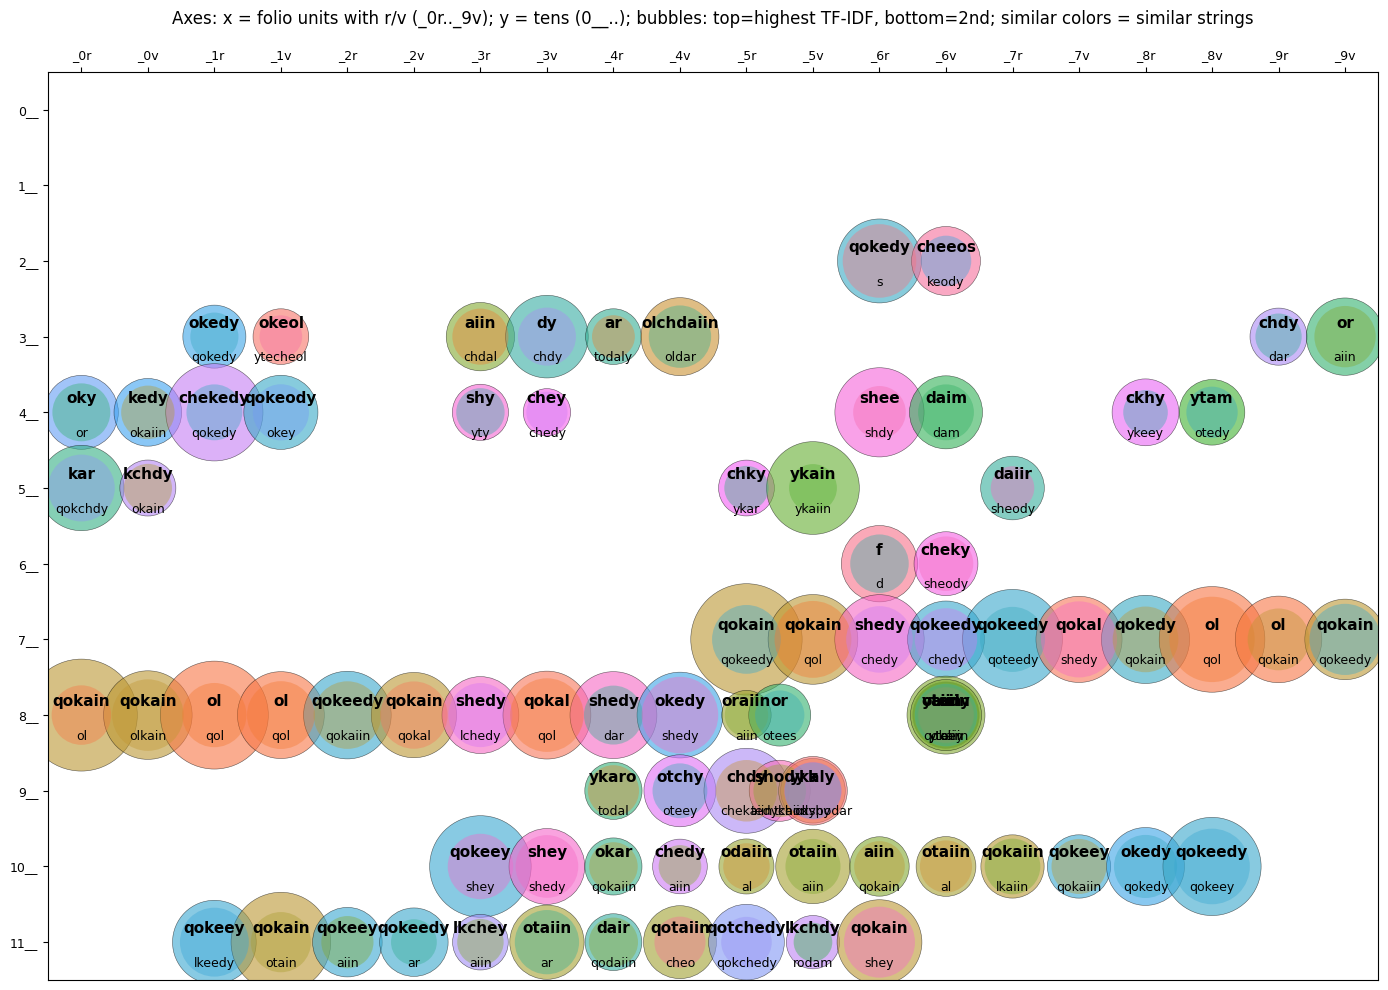

In [32]:
# Grid bubble plot: top-1 TF-IDF term per page
page_index = json.load(open("data/voynich_page_index.json"))
order_idx = {p: i for i, p in enumerate(page_index["ordered_pages"])}
top2_map = {labels[i]: tk.top_terms_for_doc(i, X, vocab, k=2) for i in range(len(labels))}
rows = []
for doc in labels:
    terms = top2_map.get(doc, [])
    if not terms:
        continue
    t1, s1 = terms[0]
    t2, s2 = (terms[1] if len(terms) > 1 else (None, 0.0))
    rows.append({"doc": doc, "term1": t1, "tfidf1": float(s1), "term2": t2, "tfidf2": float(s2), "order": order_idx.get(doc, 1e9)})
top1_df = pd.DataFrame(rows)
if top1_df.empty:
    print("No terms to plot")
else:
    from difflib import SequenceMatcher
    import re

    def folio_coords(pid):
        m = re.match(r"f(\d+)(r|v)(\d+)?", pid)
        if not m:
            return None, None
        num = int(m.group(1))
        side = m.group(2)
        suffix = m.group(3)
        tens = num // 10
        unit = num % 10
        if side == "r":
            if suffix == "2":
                x = unit * 2 + 0.5  # r2 halfway between r and v
            else:  # r or r1
                x = unit * 2
        else:  # v (including v1/v2 if ever)
            x = unit * 2 + 1
        y = tens
        return x, y

    top1_df = top1_df.sort_values("order").reset_index(drop=True)
    coords = top1_df["doc"].apply(lambda d: folio_coords(d))
    top1_df["x"] = [c[0] for c in coords]
    top1_df["y"] = [c[1] for c in coords]
    top1_df = top1_df.dropna(subset=["x", "y"])
    max_t = top1_df[["tfidf1", "tfidf2"]].max().max()
    min_size, size_span = -500, 7000
    top1_df["size1"] = min_size + (top1_df["tfidf1"] / max_t) ** 1.2 * size_span
    top1_df["size2"] = ( min_size + (top1_df["tfidf2"] / max_t) ** 1.2 * (size_span) ) * 0.8
    terms = pd.unique(top1_df[["term1", "term2"]].values.ravel("K"))
    terms = [t for t in terms if t is not None]
    if len(terms) <= 20:
        palette = dict(zip(terms, sns.color_palette("tab20", n_colors=len(terms))))
    else:
        # cluster similar strings and map nearby leaves to nearby hues
        sims = np.ones((len(terms), len(terms)))
        for i in range(len(terms)):
            for j in range(i + 1, len(terms)):
                sim = SequenceMatcher(None, terms[i], terms[j]).ratio()
                sims[i, j] = sims[j, i] = sim
        dist = 1 - sims[np.triu_indices(len(terms), 1)]
        Z = linkage(dist, method="average")
        leaves = dendrogram(Z, no_plot=True)["leaves"]
        ordered_terms = [terms[i] for i in leaves]
        palette_seq = sns.color_palette("husl", n_colors=len(ordered_terms))
        palette = {t: palette_seq[i] for i, t in enumerate(ordered_terms)}
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.scatter(top1_df.x, top1_df.y, s=top1_df["size1"], c=top1_df.term1.map(palette), alpha=0.6, edgecolor="k", linewidth=0.4, label="top1")
    if top1_df["tfidf2"].gt(0).any():
        ax.scatter(top1_df.x, top1_df.y, s=top1_df["size2"], c=top1_df.term2.map(palette), alpha=0.4, edgecolor="none", linewidth=0, label="top2")
    for _, r in top1_df.iterrows():
        ax.text(r.x, r.y - 0.18, r.term1, ha="center", va="center", fontsize=11, color="black", weight="bold")
        if r.term2:
            ax.text(r.x, r.y + 0.28, r.term2, ha="center", va="center", fontsize=9, color="black", weight="normal")
    x_ticks = list(range(20))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"_{d}{s}" for d in range(10) for s in ("r", "v")], fontsize=9)
    ax.xaxis.tick_top()
    y_max = int(top1_df["y"].max())
    y_ticks = list(range(y_max + 1))
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{t}__" for t in y_ticks], fontsize=9)
    ax.set_xlim(-0.5, 19.5)
    ax.set_ylim(y_max + 0.5, -0.5)
    ax.set_title("Axes: x = folio units with r/v (_0r.._9v); y = tens (0__..); bubbles: top=highest TF-IDF, bottom=2nd; similar colors = similar strings", pad=18)
    plt.tight_layout()
    plt.show()


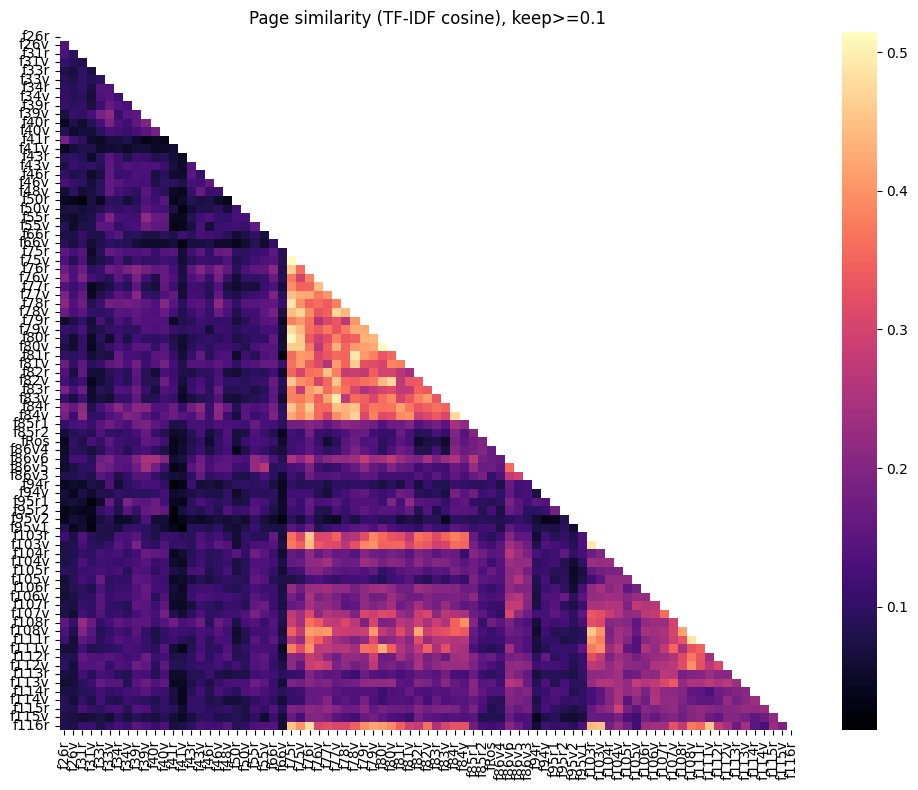

In [33]:
# Plot similarity heatmap for kept pages (max sim >= threshold)
if len(keep_labels) == 0:
    print(f"No pages exceed similarity threshold {sim_keep_threshold}")
else:
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(sim_keep, dtype=bool))
    sns.heatmap(sim_keep, mask=mask, xticklabels=keep_labels, yticklabels=keep_labels, cmap="magma", ax=ax)
    ax.set_title(f"Page similarity (TF-IDF cosine), keep>={sim_keep_threshold}")
    plt.tight_layout()
    plt.show()


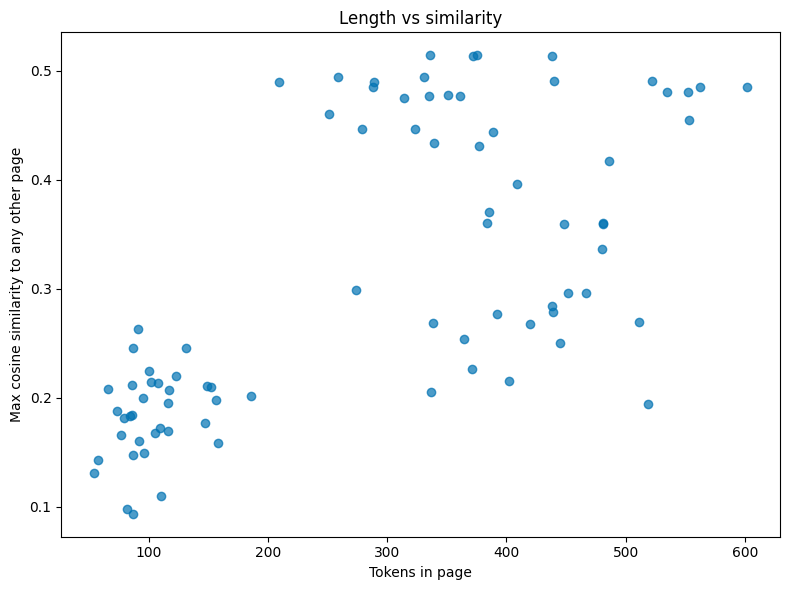

In [34]:
# Scatter: tokens per page vs max similarity to others (after any top-k pruning)
if len(labels) == 0:
    print("No documents to plot")
else:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(doc_tokens, max_sim_to_other, alpha=0.7)
    ax.set_xlabel("Tokens in page")
    ax.set_ylabel("Max cosine similarity to any other page")
    ax.set_title("Length vs similarity")
    plt.tight_layout()
    plt.show()


In [35]:
# Tabulate top-N nearest neighbors per page
neighbors_rows = []
for lbl, neigh in sim_neigh.items():
    for other, score in neigh:
        neighbors_rows.append((lbl, other, score))
neigh_df = pd.DataFrame(neighbors_rows, columns=["doc", "neighbor", "cosine"]).sort_values(["doc", "cosine"], ascending=[True, False])
display(neigh_df.head(50))


,doc,neighbor,cosine
360,f103r,f103v,0.490555
361,f103r,f108v,0.456476
362,f103r,f76r,0.453797
363,f103r,f116r,0.441213
364,f103r,f111r,0.411761
365,f103r,f79v,0.385728
366,f103v,f103r,0.490555
367,f103v,f116r,0.449652
368,f103v,f76r,0.442621
369,f103v,f108v,0.401173


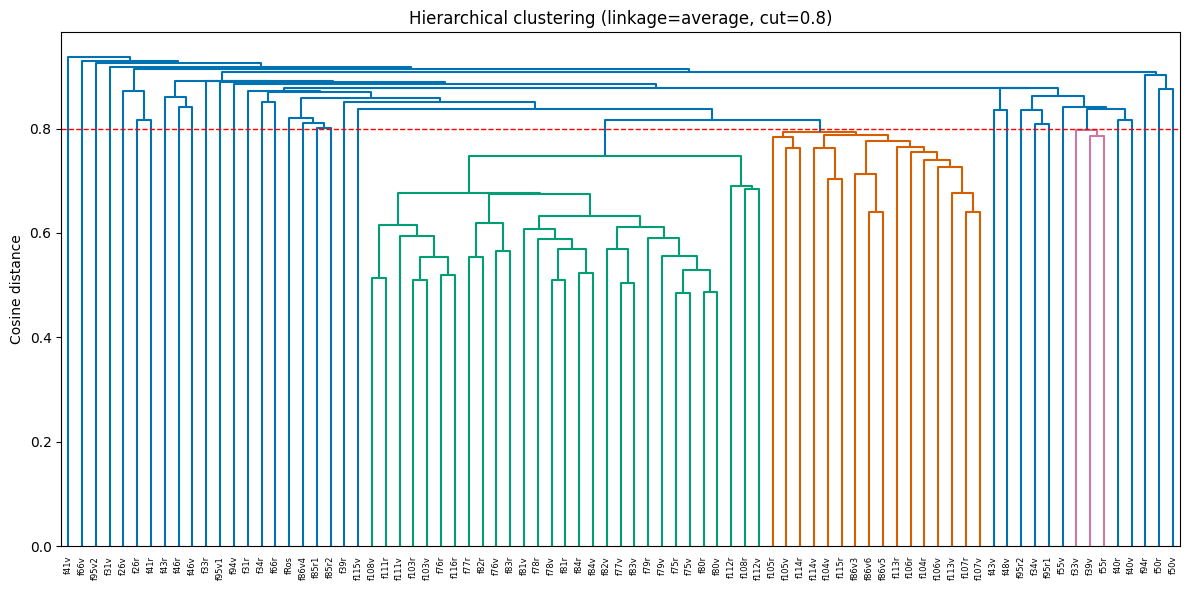

,doc,cluster
0,f26r,1
12,f41r,2
1,f26v,3
16,f46r,4
17,f46v,5
...,...,...
52,f94r,32
3,f31v,33
56,f95v2,34
24,f66v,35


In [36]:
# Hierarchical clustering on kept pages (cosine distance from pruned matrix)
if len(keep_labels) < 2:
    print("Not enough kept pages for clustering")
else:
    dist_mat = np.clip(1.0 - sim_keep, 0, 2)
    condensed = squareform(dist_mat, checks=False)
    Z = linkage(condensed, method=cluster_linkage)
    fig, ax = plt.subplots(figsize=(12, 6))
    dendrogram(Z, labels=keep_labels, leaf_rotation=90, ax=ax, color_threshold=cluster_distance_threshold)
    ax.axhline(cluster_distance_threshold, color="red", linestyle="--", linewidth=1)
    ax.set_ylabel("Cosine distance")
    ax.set_title(f"Hierarchical clustering (linkage={cluster_linkage}, cut={cluster_distance_threshold})")
    plt.tight_layout()
    plt.show()
    clusters = fcluster(Z, t=cluster_distance_threshold, criterion="distance")
    cluster_df = pd.DataFrame({"doc": keep_labels, "cluster": clusters})
    display(cluster_df.sort_values(["cluster", "doc"]))


In [37]:
# Summarize clusters: page ranges, shared terms, separation metrics
if len(keep_labels) == 0:
    print("No kept pages to summarize")
else:
    if len(keep_labels) == 1:
        clusters = np.array([1])
    cluster_df = pd.DataFrame({"doc": keep_labels, "cluster": clusters})
    order_index = {pid: i for i, pid in enumerate(tk.ordered_pages)}

    def compress_ranges(docs):
        idxs = [order_index.get(d) for d in docs if d in order_index]
        other = [d for d in docs if d not in order_index]
        idxs = sorted([i for i in idxs if i is not None])
        ranges = []
        i = 0
        while i < len(idxs):
            start = idxs[i]
            j = i
            while j + 1 < len(idxs) and idxs[j + 1] == idxs[j] + 1:
                j += 1
            if start == idxs[j]:
                ranges.append(tk.ordered_pages[start])
            else:
                ranges.append(f"{tk.ordered_pages[start]}-{tk.ordered_pages[idxs[j]]}")
            i = j + 1
        ranges.extend(other)
        return ", ".join(ranges)

    rows = []
    Xk = X_keep
    for cid, sub in cluster_df.groupby("cluster"):
        docs_in = list(sub["doc"])
        idxs = [keep_labels.index(d) for d in docs_in]
        sims = sim_keep[np.ix_(idxs, idxs)]
        if sims.size:
            np.fill_diagonal(sims, np.nan)
            intra_vals = sims[~np.isnan(sims)]
            intra_mean = float(intra_vals.mean()) if intra_vals.size else 0.0
            intra_max = float(np.nanmax(sims)) if np.isfinite(sims).any() else 0.0
        else:
            intra_mean = intra_max = 0.0
        outside = [i for i in range(sim_keep.shape[0]) if i not in idxs]
        if outside:
            cross = sim_keep[np.ix_(idxs, outside)]
            inter_mean = float(cross.mean()) if cross.size else 0.0
        else:
            inter_mean = 0.0
        # shared terms: weighted by cluster mean and lift vs rest
        cluster_vec = np.asarray(Xk[idxs].mean(axis=0)).ravel()
        if outside:
            rest_vec = np.asarray(Xk[outside].mean(axis=0)).ravel()
        else:
            rest_vec = np.zeros_like(cluster_vec)
        lift = (cluster_vec + 1e-9) / (rest_vec + 1e-9)
        score = cluster_vec * lift
        top_idx = np.argsort(score)[::-1][:n_cluster_terms]
        top_terms = [(vectorizer.get_feature_names_out()[j], float(cluster_vec[j]), float(lift[j])) for j in top_idx if cluster_vec[j] > 0]
        rows.append({
            "cluster": cid,
            "size": len(docs_in),
            "pages": compress_ranges(docs_in),
            "intra_mean": intra_mean,
            "intra_max": intra_max,
            "inter_mean": inter_mean,
            "top_terms": top_terms,
        })

    cluster_summary = pd.DataFrame(rows).sort_values(["size"], ascending=False)
    display(cluster_summary)



,cluster,size,pages,intra_mean,intra_max,inter_mean,top_terms
12,13,29,"f75r-f84v, f103r-f103v, f108r-f112v, f116r",0.333476,0.514433,0.138634,"[(lshey, 0.019238266849032896, 19238267.849032..."
13,14,16,"f86v6-f86v3, f104r-f107v, f113r-f115r",0.225074,0.360056,0.145142,"[(qopchy, 0.016844988753210888, 16844989.75321..."
22,23,3,"f33v, f39v, f55r",0.206107,0.213799,0.122222,"[(lchoar, 0.057647778566580606, 57647779.56658..."
0,1,1,f26r,0.000000,0.000000,0.097092,"[(chypchey, 0.1811683692394515, 181168370.2394..."
3,4,1,f46r,0.000000,0.000000,0.098101,"[(sheoteoly, 0.1051147405230477, 105114741.523..."
2,3,1,f26v,0.000000,0.000000,0.085350,"[(qodary, 0.14503499355444185, 145034994.55444..."
1,2,1,f41r,0.000000,0.000000,0.078707,"[(ytcheeky, 0.14349615642507646, 143496157.425..."
4,5,1,f46v,0.000000,0.000000,0.118007,"[(saim, 0.14161116248965774, 141611163.4896577..."
8,9,1,f85r1,0.000000,0.000000,0.160727,"[(yoiin, 0.07189433779827578, 71894338.7982757..."
9,10,1,f85r2,0.000000,0.000000,0.121345,"[(sodaiiin, 0.10787842719939504, 107878428.199..."


In [38]:
# Detailed per-cluster breakdown with top shared terms
if len(keep_labels) == 0:
    print("No kept pages to detail")
else:
    if len(keep_labels) == 1:
        clusters = np.array([1])
    cluster_df = pd.DataFrame({"doc": keep_labels, "cluster": clusters})
    order_index = {pid: i for i, pid in enumerate(tk.ordered_pages)}

    def compress_ranges(docs):
        idxs = [order_index.get(d) for d in docs if d in order_index]
        other = [d for d in docs if d not in order_index]
        idxs = sorted([i for i in idxs if i is not None])
        ranges = []
        i = 0
        while i < len(idxs):
            start = idxs[i]
            j = i
            while j + 1 < len(idxs) and idxs[j + 1] == idxs[j] + 1:
                j += 1
            if start == idxs[j]:
                ranges.append(tk.ordered_pages[start])
            else:
                ranges.append(f"{tk.ordered_pages[start]}-{tk.ordered_pages[idxs[j]]}")
            i = j + 1
        ranges.extend(other)
        return ", ".join(ranges)

    for cid, sub in cluster_df.groupby("cluster"):
        docs_in = list(sub["doc"])
        if len(docs_in) <= 1: continue
        idxs = [keep_labels.index(d) for d in docs_in]
        outside = [i for i in range(sim_keep.shape[0]) if i not in idxs]
        cluster_vec = np.asarray(X_keep[idxs].mean(axis=0)).ravel()
        if outside:
            rest_vec = np.asarray(X_keep[outside].mean(axis=0)).ravel()
        else:
            rest_vec = np.zeros_like(cluster_vec)
        lift = (cluster_vec + 1e-9) / (rest_vec + 1e-9)
        score = cluster_vec * lift
        top_idx = np.argsort(score)[::-1][:n_cluster_terms]
        top_terms = [(vectorizer.get_feature_names_out()[j], float(cluster_vec[j]), float(lift[j])) for j in top_idx if cluster_vec[j] > 0]
        print(f"Cluster {cid} (n={len(docs_in)}): {compress_ranges(docs_in)}")
        print("  Top shared terms (score = mean_tf_idf * lift vs rest):")
        for term, mean_w, lift_w in top_terms:
            print(f"    {term:15s} mean_tfidf={mean_w:.4f} lift={lift_w:.2f}")
        # indicator: intra vs inter
        sims = sim_keep[np.ix_(idxs, idxs)]
        if sims.size:
            np.fill_diagonal(sims, np.nan)
            intra_vals = sims[~np.isnan(sims)]
            intra_mean = float(intra_vals.mean()) if intra_vals.size else 0.0
        else:
            intra_mean = 0.0
        if outside:
            cross = sim_keep[np.ix_(idxs, outside)]
            inter_mean = float(cross.mean()) if cross.size else 0.0
        else:
            inter_mean = 0.0
        print(f"  Intra-mean={intra_mean:.3f}, Inter-mean={inter_mean:.3f}\n")


Cluster 13 (n=29): f75r-f84v, f103r-f103v, f108r-f112v, f116r
  Top shared terms (score = mean_tf_idf * lift vs rest):
    lshey           mean_tfidf=0.0192 lift=19238267.85
    olshey          mean_tfidf=0.0175 lift=17547478.36
    shedal          mean_tfidf=0.0165 lift=16510808.81
    qolchedy        mean_tfidf=0.0160 lift=16017249.88
    qolchey         mean_tfidf=0.0147 lift=14651498.26
    sheety          mean_tfidf=0.0133 lift=13304161.61
    qoly            mean_tfidf=0.0116 lift=11578587.00
    shckhedy        mean_tfidf=0.0114 lift=11379306.62
  Intra-mean=0.333, Inter-mean=0.139

Cluster 14 (n=16): f86v6-f86v3, f104r-f107v, f113r-f115r
  Top shared terms (score = mean_tf_idf * lift vs rest):
    qopchy          mean_tfidf=0.0168 lift=16844989.75
    chotar          mean_tfidf=0.0158 lift=15770158.73
    qoedy           mean_tfidf=0.0142 lift=14229068.04
    chokar          mean_tfidf=0.0139 lift=13912107.36
    ail             mean_tfidf=0.0131 lift=13113809.49
    choaiin   

In [39]:
# Least-informative words: high document frequency and low TF-IDF variance
if X.shape[0] == 0:
    print("No documents loaded")
else:
    df = (X > 0).sum(axis=0).A1 / X.shape[0]
    mean = np.asarray(X.mean(axis=0)).ravel()
    var = np.asarray(X.power(2).mean(axis=0)).ravel() - mean ** 2
    vocab_arr = vectorizer.get_feature_names_out()
    df_thresh = 0.5  # keep terms appearing in at least 50% of docs
    top_n_bland = 50
    idx = np.where(df >= df_thresh)[0]
    sorted_idx = idx[np.argsort(var[idx])]
    rows = []
    for j in sorted_idx[:top_n_bland]:
        rows.append({
            "term": vocab_arr[j],
            "df_frac": float(df[j]),
            "tfidf_mean": float(mean[j]),
            "tfidf_var": float(var[j]),
        })
    bland_df = pd.DataFrame(rows)
    display(bland_df)



,term,df_frac,tfidf_mean,tfidf_var
0,y,0.674699,0.025235,0.000682
1,sheedy,0.506024,0.023435,0.000822
2,okeedy,0.578313,0.026926,0.000908
3,okal,0.626506,0.030464,0.001005
4,chckhy,0.698795,0.033699,0.001085
5,sheey,0.530120,0.027481,0.001182
6,otar,0.650602,0.032816,0.001255
7,saiin,0.518072,0.026770,0.001287
8,cheey,0.566265,0.031117,0.001304
9,s,0.602410,0.027567,0.001541
